In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
from qutip import *
from scipy.constants import *

In [6]:
N_qubits = 11
qubit_dimension = 3
transmon_diagonalization_dimension = 15
print(qubit_dimension**N_qubits)

177147


In [7]:
J = 0.058*2*pi
central_E_C = 0.155*2*pi
#central_E_J = (12307311816.10025+2053555641.5778756)/1e9*2*pi

central_E_J = (11300+1315)/1e3*2*pi
sigma_factor = 0.00
E_Cs = abs(random.normal(central_E_C, sigma_factor*central_E_C, size = N_qubits))
# E_Cs = array((0.16896701340450096,
#               0.1618561821691958,
#               0.16185256844572862,
#               0.1618561821691958,
#               0.16896701340450096))*2*pi
E_Js = abs(random.normal(central_E_J, sigma_factor*central_E_J, size = N_qubits))
(sqrt(8*E_Cs*E_Js)-E_Cs)/2/pi

array([3.80007269, 3.80007269, 3.80007269, 3.80007269, 3.80007269,
       3.80007269, 3.80007269, 3.80007269, 3.80007269, 3.80007269,
       3.80007269])

In [8]:
J = 0.058*2*pi
central_E_C = 0.155*2*pi
#central_E_J = (12307311816.10025+2053555641.5778756)/1e9*2*pi

central_E_J = (11100+1198)/1e3*2*pi
sigma_factor = 0.00
E_Cs = abs(random.normal(central_E_C, sigma_factor*central_E_C, size = N_qubits))
# E_Cs = array((0.16896701340450096,
#               0.1618561821691958,
#               0.16185256844572862,
#               0.1618561821691958,
#               0.16896701340450096))*2*pi
E_Js = abs(random.normal(central_E_J, sigma_factor*central_E_J, size = N_qubits))
(sqrt(8*E_Cs*E_Js)-E_Cs)/2/pi

array([3.75006338, 3.75006338, 3.75006338, 3.75006338, 3.75006338,
       3.75006338, 3.75006338, 3.75006338, 3.75006338, 3.75006338,
       3.75006338])

In [7]:
central_E_J

77.27061290769456

$$
H = \sum_{j=0}^{N_q} \hat H_{tr}^j + \sum_{j=0}^{N_q-1} J_j \hat n_j \hat n_{j+1}
$$

$$
\hat H_{tr}^j = 4 E_c^j \hat n_j^2 - E_J^j \cos \hat \phi = 4 E_c^j \hat n_j^2 - E_J^j/2 \left[ \sum_{-\infty}^{+\infty} \left | n \right\rangle \left\langle n-1\right| + \left | n-1 \right\rangle \left\langle n\right| \right]
$$

In [9]:
 'J1': 0.013269317721392351,
 'J2': 0.0038131487981033206,

SyntaxError: invalid syntax (<ipython-input-9-8f44af3ccb6f>, line 1)

In [10]:
coupling = array([50, 15]*5 )/1e3*2*pi
array(coupling)

array([0.31415927, 0.09424778, 0.31415927, 0.09424778, 0.31415927,
       0.09424778, 0.31415927, 0.09424778, 0.31415927, 0.09424778])

In [11]:
def n():
    return charge(transmon_diagonalization_dimension//2)

def build_H_tr(E_C, E_J):
    return 4*E_C*n()**2 - E_J/2*(tunneling(transmon_diagonalization_dimension))

def build_model_qubit(E_C = 0.155*2*pi, E_J = 77.27):
    full_qubit = build_H_tr(E_C, E_J)
    evals, evecs = full_qubit.eigenstates()
    return Qobj(full_qubit.transform(evecs).full()[:qubit_dimension,:qubit_dimension])

def build_model_sigmax(E_C = 0.155*2*pi, E_J = 77.27):
    full_qubit = build_H_tr(E_C, E_J)
    evals, evecs = full_qubit.eigenstates()
    n_trunc_eig = n().transform(evecs).full()[:qubit_dimension,:qubit_dimension]
    full_sigmax = n()/n_trunc_eig[0,1]
    return Qobj(full_sigmax.transform(evecs).full()[:qubit_dimension,:qubit_dimension])

def build_model_sigmaz(E_C =  0.155*2*pi, E_J = 77.27):
    return create(qubit_dimension)*destroy(qubit_dimension)


def build_multiqubit_identity_array():
    return [qeye(qubit_dimension) for i in range(0, N_qubits)]

def build_multiqubit_zero_operator():
    return tensor(*[qzero(qubit_dimension) for i in range(0, N_qubits)])

def build_qubit_at_index(N):
    multiqubit_operator = build_multiqubit_identity_array()
    multiqubit_operator[N] = build_model_qubit(E_Cs[N], E_Js[N])
    return tensor(*multiqubit_operator)

def build_interaction(Q1_idx, Q2_idx):
    multiqubit_operator = build_multiqubit_identity_array()
    multiqubit_operator[Q1_idx] = build_model_sigmax(E_Cs[Q1_idx], E_Js[Q1_idx])
    multiqubit_operator[Q2_idx] = build_model_sigmax(E_Cs[Q2_idx], E_Js[Q2_idx])
    return coupling[Q1_idx]*tensor(*multiqubit_operator)

def build_H_chain():
    H_chain = build_multiqubit_zero_operator()
    for i in range(0, N_qubits):
        H_chain += build_qubit_at_index(i)
    for i in range(0, N_qubits-1):
        H_chain += build_interaction(i, i+1)
    return H_chain

def build_H_dr(i, omega, amplitude, phase):
    H_dr = build_multiqubit_identity_array()
    full_qubit = build_H_tr(E_Cs[i], E_Js[i])
    evals, evecs = full_qubit.eigenstates()
    n_trunc_eig = n().transform(evecs).full()[:qubit_dimension,:qubit_dimension]
    full_sigmax = n()/n_trunc_eig[0,1]
    H_dr[i] = Qobj(full_sigmax.transform(evecs).full()[:qubit_dimension,:qubit_dimension])
    return [tensor(*H_dr), "%.15f*sin(%.15f*t + %.15f)"%(amplitude, omega, phase)]

def build_c(i, gamma):
    c = build_multiqubit_identity_array()
    full_qubit = build_H_tr(E_Cs[i], E_Js[i])
    evals, evecs = full_qubit.eigenstates()
    n_trunc_eig = n().transform(evecs).full()[:qubit_dimension,:qubit_dimension]
    c[i] = sum([basis(qubit_dimension, j-1)*basis(qubit_dimension, j).dag()*n_trunc_eig[j-1,j] 
            for j in range(1, qubit_dimension)])
    return tensor(*c)*sqrt(gamma)

In [12]:
H_chain = build_H_chain()
print("Built chain...")

Built chain...


In [13]:
#trancated state space size
num_states = 1 + N_qubits + N_qubits*(N_qubits+1)//2
num_states

78

In [14]:
evals, evecs = H_chain.eigenstates(sparse=True, eigvals=num_states)
print("Diagonalized!") 

Diagonalized!


In [19]:
# excitation operator 
excitation_qubit_id = 10
excitation_operator = tensor(*[qeye(qubit_dimension) if excitation_qubit_id != q else build_model_sigmax()
                              for q in range(N_qubits)])

exc_oper = []
for evec1 in evecs:
    row = []
    for evec2 in evecs:
        row.append(excitation_operator.matrix_element(evec1, evec2))
    exc_oper.append(row)
excitation_operator = Qobj(exc_oper)

In [20]:
proj_qubit_id = 0
state = 1
proj_operator = tensor(*[qeye(qubit_dimension) if proj_qubit_id != q else ket2dm(basis(qubit_dimension, 1))
                              for q in range(N_qubits)])

proj_oper = []
for evec1 in evecs:
    row = []
    for evec2 in evecs:
        row.append(proj_operator.matrix_element(evec1, evec2))
    proj_oper.append(row)
proj_operator = Qobj(proj_oper)

In [23]:
psi0 = evecs[0]

In [24]:
H_trunc=Qobj(np.diag(evals))

In [25]:
pso0=H_trunc.eigenstates()[1][0]

In [ ]:
tensor(*evecs)

In [32]:
psi0=evecs[:num_states]

In [26]:
import numpy as np

In [31]:
tlist=np.linspace(0,300,201)
nop=15
sz_final = np.zeros(nop)
freqs=np.linspace(3.65,3.85,nop)
options= Options(nsteps=10000)
drive_envelope= 'A*cos(t*fr*2*pi)'
for _id,fr in enumerate(freqs):
    H_driven=[H_trunc,[excitation_operator,drive_envelope]]
    output = mesolve(H=H_driven,rho0 = psi0,
                     tlist=tlist, c_ops=[],
                     e_ops=proj_operator,
                     args=
                    {'A':2e-1,'fr':float(fr),'pi':float(pi)},
                    options = options)
    sz_final[_id] = np.mean(((output.expect[0]+1)/2)[-100:])

C:\Users\Ivan\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Ivan\Desktop\rhs115684.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
C:\Users\Ivan\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Ivan\Desktop\rhs115685.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
C:\Users\Ivan\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Ivan\Desktop\rhs115686.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
C:\Users\Ivan\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2).

KeyboardInterrupt: 

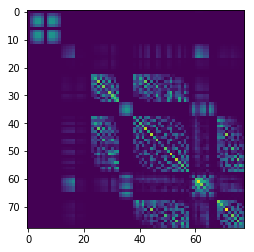

In [21]:
imshow(abs(Qobj(proj_operator).full()))

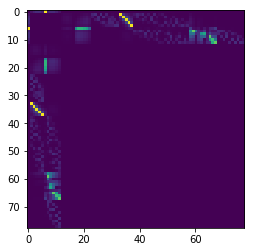

In [22]:
imshow(abs(Qobj(exc_oper).full()))

(3.61, 3.82)

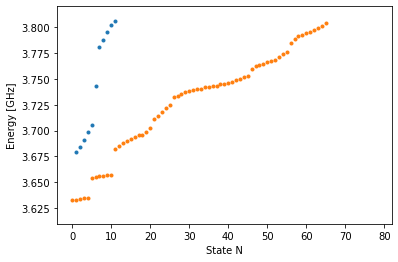

In [203]:
plot((evals-evals[0])/2/pi, ".")
plot((evals[12:78]-evals[0])/2/pi/2, ".")
plot((evals[79:]-evals[0])/2/pi/3, ".")
# plot(ones_like(evals)-0.05*len(evals), (evals-evals[0])/2/pi, ".")
xlabel("State N")
ylabel("Energy [GHz]")

plt.ylim(3.965,3.97)
plt.ylim(3.61,3.82)

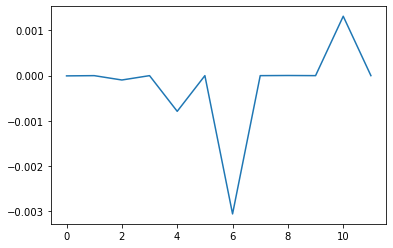

In [198]:
plot(np.real(evecs[48].full()[:12]))

In [135]:
def calculate_projections(state, truncation=-1, qubit_level=1):
    projections = []
    for i in range(0, N_qubits):
        projector = build_multiqubit_identity_array()
        projector[i] = ket2dm(basis(qubit_dimension,qubit_level))
        projector = tensor(*projector)
        if truncation > 0:
            projections.append(expect(Qobj(projector[:truncation, :truncation], state)))
        else:
            projections.append(expect(projector, state))
    return projections

In [200]:
build_model_sigmax()


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.         1.         0.        ]
 [1.         0.         1.38112556]
 [0.         1.38112556 0.        ]]

In [224]:
basis_full = tensor(*build_multiqubit_identity_array())
max_excitation_num = 2
num_levels
basis_full
for state_id, state in enumerate(basis_full):\
    for qubit_level in 
    sum(calculate_projections(state, qubit_level=))

Quantum object: dims = [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]], shape = (177147, 177147), type = oper, isherm = True
Qobj data =
  (0, 0)	(1+0j)
  (1, 1)	(1+0j)
  (2, 2)	(1+0j)
  (3, 3)	(1+0j)
  (4, 4)	(1+0j)
  (5, 5)	(1+0j)
  (6, 6)	(1+0j)
  (7, 7)	(1+0j)
  (8, 8)	(1+0j)
  (9, 9)	(1+0j)
  (10, 10)	(1+0j)
  (11, 11)	(1+0j)
  (12, 12)	(1+0j)
  (13, 13)	(1+0j)
  (14, 14)	(1+0j)
  (15, 15)	(1+0j)
  (16, 16)	(1+0j)
  (17, 17)	(1+0j)
  (18, 18)	(1+0j)
  (19, 19)	(1+0j)
  (20, 20)	(1+0j)
  (21, 21)	(1+0j)
  (22, 22)	(1+0j)
  (23, 23)	(1+0j)
  (24, 24)	(1+0j)
  :	:
  (177122, 177122)	(1+0j)
  (177123, 177123)	(1+0j)
  (177124, 177124)	(1+0j)
  (177125, 177125)	(1+0j)
  (177126, 177126)	(1+0j)
  (177127, 177127)	(1+0j)
  (177128, 177128)	(1+0j)
  (177129, 177129)	(1+0j)
  (177130, 177130)	(1+0j)
  (177131, 177131)	(1+0j)
  (177132, 177132)	(1+0j)
  (177133, 177133)	(1+0j)
  (177134, 177134)	(1+0j)
  (177135, 177135)	(1+0j)
  (177136, 177136)	(1+0j)
  (177137, 177

In [136]:
(evals[6]-evals[0])/2/pi, (evals[49]-evals[0])/2/pi/2,

(3.7431639024558803, 3.7432818309842846)

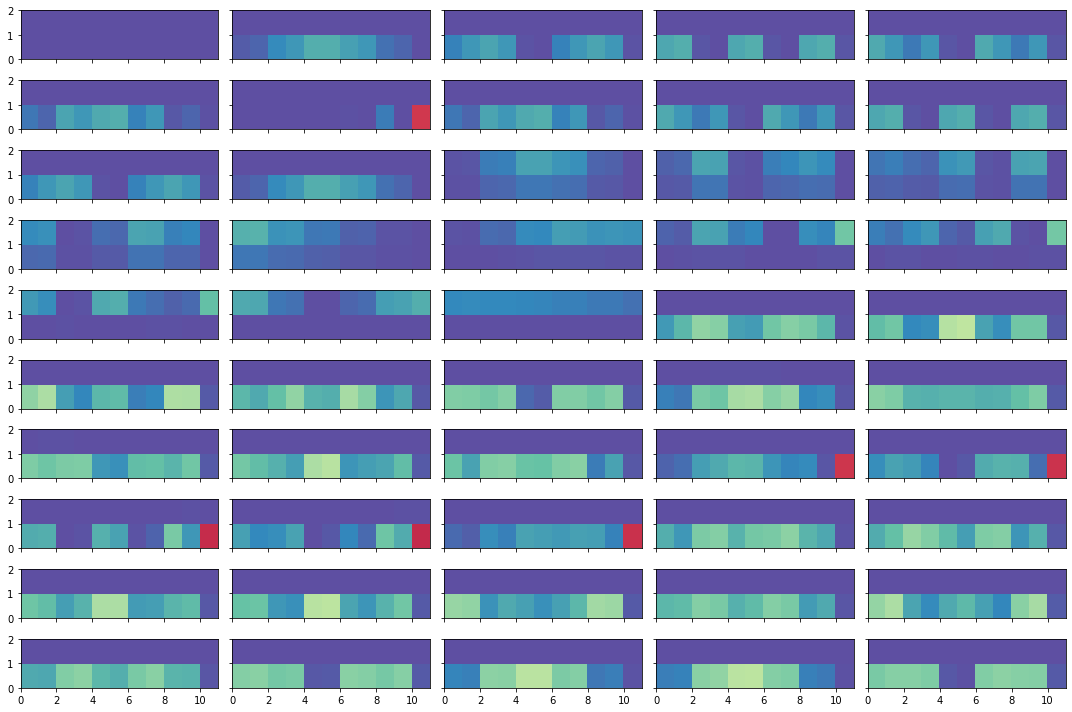

In [137]:
fig, axes = plt.subplots(10,5, figsize = (15,10), sharex=True, sharey=True)
for vec, ax in zip(evecs, axes.ravel()):
    state_map = []
    for qubit_level in range(1,qubit_dimension):
        state_map.append(calculate_projections(vec, qubit_level=qubit_level))
    m = ax.pcolormesh((array(state_map)), vmin=0, vmax=1, cmap = "Spectral_r")
tight_layout()

In [221]:
np.sum(calculate_projections(evecs[22],qubit_level=1))+np.sum(calculate_projections(evecs[22],qubit_level=2)), 

(1.000431025265729,)

In [220]:
np.abs(evecs[15]).shape

(177147, 1)

In [212]:
array(state_map)

array([[2.27448069e-01, 2.48949017e-01, 2.47180370e-01, 2.36812139e-01,
        1.60708094e-02, 7.04682461e-03, 2.39213823e-01, 2.54507368e-01,
        2.49347250e-01, 2.44679589e-01, 2.02765276e-02],
       [8.12620534e-05, 1.02568416e-03, 3.66964285e-05, 1.12290383e-03,
        2.32624422e-05, 2.40437000e-05, 7.89259898e-05, 8.54693544e-04,
        4.68537436e-05, 1.28335809e-03, 2.92951903e-07]])

In [153]:
imshow(log10(H_chain.full().real))
plt.gcf().set_size_inches(5, 5)

MemoryError: Unable to allocate array with shape (177147, 177147) and data type complex128

In [99]:
amplitude = 0.01*2*pi
phase = 0
N = 0
omega = evals[N+1]-evals[0]
gamma = 0.1

In [100]:
(evals[1:11]-evals[0])/2/pi

array([3.72931231, 3.73387243, 3.74072087, 3.74858214, 3.75533496,
       3.79327223, 3.83086187, 3.83746942, 3.84513293, 3.85178391])

In [101]:
build_H_dr(0, omega, 0, phase)[0]

Quantum object: dims = [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]], shape = (177147, 177147), type = oper, isherm = True
Qobj data =
  (0, 59049)	(0.9999999999999997+0j)
  (1, 59050)	(0.9999999999999997+0j)
  (2, 59051)	(0.9999999999999997+0j)
  (3, 59052)	(0.9999999999999997+0j)
  (4, 59053)	(0.9999999999999997+0j)
  (5, 59054)	(0.9999999999999997+0j)
  (6, 59055)	(0.9999999999999997+0j)
  (7, 59056)	(0.9999999999999997+0j)
  (8, 59057)	(0.9999999999999997+0j)
  (9, 59058)	(0.9999999999999997+0j)
  (10, 59059)	(0.9999999999999997+0j)
  (11, 59060)	(0.9999999999999997+0j)
  (12, 59061)	(0.9999999999999997+0j)
  (13, 59062)	(0.9999999999999997+0j)
  (14, 59063)	(0.9999999999999997+0j)
  (15, 59064)	(0.9999999999999997+0j)
  (16, 59065)	(0.9999999999999997+0j)
  (17, 59066)	(0.9999999999999997+0j)
  (18, 59067)	(0.9999999999999997+0j)
  (19, 59068)	(0.9999999999999997+0j)
  (20, 59069)	(0.9999999999999997+0j)
  (21, 59070)	(0.9999999999999997+0j)
  (22, 59071)	

In [102]:
build_H_dr(0, omega, 0, phase)[0].matrix_element(evecs[0], evecs[5])

(0.04407678675812178-0.26803198016594215j)

In [23]:
options = Options(nsteps=10000)
Ts = linspace(0, 50, 1000)
# result = mesolve([H_chain, build_H_dr(0, omega, amplitude, phase)], (evecs[0]),
#                  Ts, c_ops=[], progress_bar=True, options=options)  #build_c(0, gamma), build_c(4, gamma)


initial_state_array = [1,0,0,0,0,0,0,0,0]
initial_state = ket(initial_state_array, qubit_dimension)
result = mesolve(H_chain, initial_state,
                 Ts, c_ops=[], progress_bar=True, options=options)

10.0%. Run time:   2.43s. Est. time left: 00:00:00:21
20.0%. Run time:   4.78s. Est. time left: 00:00:00:19
30.0%. Run time:   7.10s. Est. time left: 00:00:00:16
40.0%. Run time:   9.42s. Est. time left: 00:00:00:14
50.0%. Run time:  11.75s. Est. time left: 00:00:00:11
60.0%. Run time:  14.06s. Est. time left: 00:00:00:09
70.0%. Run time:  16.39s. Est. time left: 00:00:00:07
80.0%. Run time:  18.77s. Est. time left: 00:00:00:04
90.0%. Run time:  21.12s. Est. time left: 00:00:00:02
Total run time:  23.52s


In [24]:
projections = array([calculate_projections(state) for state in result.states[:]])

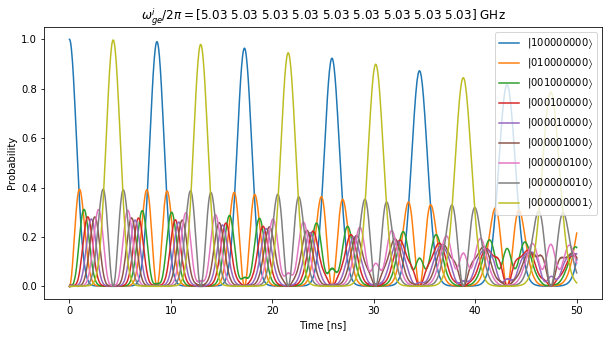

In [25]:
for idx, projection in enumerate(projections.T):
    state = list("0"*N_qubits)
    state[idx]="1"
    state = "".join(state)
    plot(Ts[:], projection, label = r"$\left.|%s\right>$"%state)
legend()
ylabel("Probability")
xlabel("Time [ns]")
title("$\omega_{ge}^i/2\pi=$"+str(around((sqrt(8*E_Cs*E_Js)-E_Cs)/2/pi,2))+ " GHz")
plt.gcf().set_size_inches(10,5)
# plt.savefig("Pics/chain_mode_3lvl_%i.pdf"%N, bbox_inches="tight")
# plt.xlim(0,100)

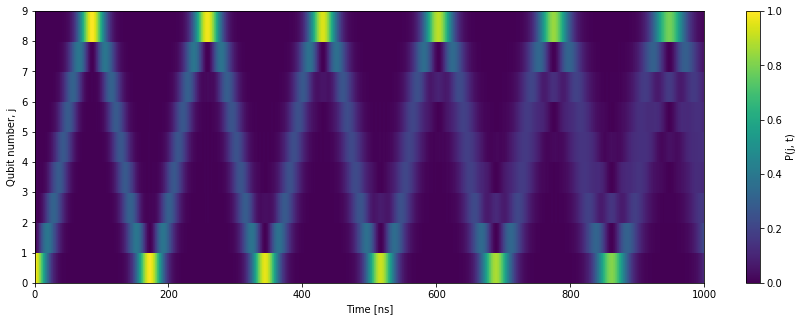

In [26]:
pcolormesh(projections[:].T)
plt.gcf().set_size_inches(15,5)
plt.ylabel("Qubit number, j")
plt.xlabel("Time [ns]")
cb = plt.colorbar()
cb.set_label("P(j, t)")

In [24]:
from scipy.fftpack import fft, fftfreq, fftshift

In [28]:
noise = np.random.normal(loc=0, scale=1, size=1000)

In [38]:
def interpolate_step(x_known, y_known, x):
    y = []
    known_idx = 0
    for point in x:
        if point<=x_known[known_idx+1]:
            y.append(y_known[known_idx])
        else:
            known_idx+=1
            y.append(y_known[known_idx])
    return y

In [72]:
plot(abs((sin(linspace(-pi, pi, 100)/linspace(-pi, pi, 100)))))

In [42]:
x = linspace(0, 2*pi, 11)
y = sin(x)
x_highres = linspace(0, 2*pi, 1001)
plot(x, y)
plot(x_highres, interpolate_step(x, y, x_highres))

In [32]:
fft_noise = fftshift(fft(noise))
freqs = fftshift(fftfreq(len(noise), d=.1))
plot(freqs, abs(fft_noise))

In [57]:
Ts = linspace(0, 500, 501)
noise = np.random.normal(size = len(Ts))+1j*np.random.normal(size = len(Ts))
UHF_Ts = linspace(0, 500, 50001)
carrier = exp(1j*2*pi*5*UHF_Ts)

In [59]:
plot(UHF_Ts, real(carrier*interpolate_step(Ts, noise, UHF_Ts)))

In [83]:
plot(abs(fft(real(carrier*interpolate_step(Ts, noise, UHF_Ts)))))

In [66]:
spectra = []
for i in range(0, 500):
    noise = np.random.normal(size = len(Ts))+1j*np.random.normal(size = len(Ts))
    carrier = exp(1j*2*pi*5*UHF_Ts)
    spectra.append(abs(fft(real(carrier*interpolate_step(Ts, noise, UHF_Ts)))))
spectra = array(spectra)

In [67]:
plot(mean(spectra, axis=0))

In [98]:
f = 2*pi*0.001
results = []
for i in range(0, 50):
    print(i, end=" ")
    noise = np.random.normal(size = len(Ts))+1j*np.random.normal(size = len(Ts))
    results.append(mesolve([[f*sigmax(), real(noise)], 
                            [f*sigmay(), imag(noise)]], 
                               basis(2,1), Ts, [], [sigmax(), sigmay(), sigmaz()]))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [84]:
for data in result.expect:
    plot(Ts, data)

In [99]:
res_data = [result.expect for result in results]

In [100]:
for sigma_alpha in mean(array(res_data), axis=0):
    plot(Ts, sigma_alpha)